In [6]:
import torch as th
import numpy as np
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
sys.path.insert(0, "/home/mint/Dev/SkelAg/DiffSynth-Studio")

from diffsynth.models.wan_video_dit import DiTBlock, SelfAttention, rearrange, precompute_freqs_cis_3d, precompute_freqs_cis, sinusoidal_embedding_1d
from diffsynth.models.wan_video_vae import Decoder3d, CausalConv3d, VideoVAE_, WanVideoVAE

n_timesteps = 1000
use_time = [1000]
n_blocks = 30
use_block = [30]
B = 1
D = 1536
F = 256    # Flattened spatial-temporal dimension (1+T/4 * H/16 * W/16); H, W = 128
feats_dim = (B, F, D)

feats = np.zeros((n_timesteps, n_blocks, B, F, D), dtype=np.uint8)
print(feats.shape)

use_feats = []
for t in use_time:
    for b in use_block:
        # print(f"t: {t}, b: {b}")
        use_feats.append(feats[t-1, b-1])
        # print(use_feats[0].shape)

use_feats = th.tensor(np.stack(use_feats, axis=0))
print("use_feats shape:", use_feats.shape)


(1000, 30, 1, 256, 1536)
use_feats shape: torch.Size([1, 1, 256, 1536])


In [7]:
from einops import repeat, reduce
from PIL import Image
def vae_output_to_video(vae_output, pattern="B C T H W", min_value=-1, max_value=1):
    # Transform a torch.Tensor to list of PIL.Image
    if pattern != "T H W C":
        vae_output = reduce(vae_output, f"{pattern} -> T H W C", reduction="mean")
    video = [vae_output_to_image(image, pattern="H W C", min_value=min_value, max_value=max_value) for image in vae_output]
    return video
def vae_output_to_image(vae_output, pattern="B C H W", min_value=-1, max_value=1):
    # Transform a torch.Tensor to PIL.Image
    if pattern != "H W C":
        vae_output = reduce(vae_output, f"{pattern} -> H W C", reduction="mean")
    image = ((vae_output - min_value) * (255 / (max_value - min_value))).clip(0, 255)
    image = image.to(device="cpu", dtype=th.uint8)
    image = Image.fromarray(image.numpy())
    return image

num_heads = 8
D = 1536
J = 5
head_dim = D // num_heads  # 192
print("head_dim:", head_dim)

x_flat = rearrange(use_feats, 'n b f d -> b (n f) d').cuda().float()   # [1, 4096, 1536]
print("x_flat shape:", x_flat.shape)

self_attn = SelfAttention(dim=D, num_heads=num_heads).to(x_flat.device)
# decoder = Decoder3d(dim=96, z_dim=16, dim_mult=[1, 2, 4, 4], num_res_blocks=2,
#                             attn_scales=[], temporal_upsample=[False, True, True])
decoder = Decoder3d().cuda()

# 1D RoPE over sequence length
freqs = precompute_freqs_cis(head_dim, end=x_flat.shape[1], theta=10000.0).to(x_flat.device)
print("SelfAttention:", self_attn)
print("freqs.shape:", freqs.shape)
print("x_flat.shape:", x_flat.shape)

freqs = freqs[None, :, None, :]
out_flat = self_attn(x_flat, freqs=freqs)       # [1, 4096, 1536]
print("out_flat shape:", out_flat.shape)
out = rearrange(out_flat, 'b (n f) d -> n b f d', n=len(use_time) * len(use_block), f=F)
print("out shape:", out.shape)

grid_size = [16, 4, 4]
patch_size = [1, 2, 2]

head = th.nn.Linear(D, 64).to(out.device)
out = head(out)
print("out shape after head:", out.shape)

joint_head = th.nn.Linear(F, F * J).to(out.device)
out = rearrange(out, 'n b f d -> n b d f')
print(out.shape)
out = joint_head(out)
print("out shape after joint_head:", out.shape)
out_joint_combined = rearrange(out, 'n b d (j f) -> n b j f d', j=J)
print("out_joint_combined shape:", out_joint_combined.shape)


#TODO: Should be replace with some layers, Pooling, etc. to combined the multiple time/block features
out = out_joint_combined.squeeze(0)  # [B, F, C]
print("out shape after squeeze:", out.shape)
out_unpatch = rearrange(
            out, 'b j (f h w) (x y z c) -> b j c (f x) (h y) (w z)',
            f=grid_size[0], h=grid_size[1], w=grid_size[2], 
            x=patch_size[0], y=patch_size[1], z=patch_size[2], j = J
        )
print("out_unpatch shape:", out_unpatch.shape)

tiled = False
tile_size = None
tile_stride = None
video_vae = WanVideoVAE().cpu()
out_unpatch = out_unpatch.cpu()

out_joint = []
import tqdm
for i in tqdm.tqdm(range(J), desc="Decoding joints"):
    video = video_vae.decode(out_unpatch[0:1, i, ...], device=out_unpatch.device, tiled=tiled, tile_size=tile_size, tile_stride=tile_stride)
    out_joint.append(video)
    print("video shape:", video.shape)
# video = vae_output_to_video(video)
# print("video length:", len(video))


head_dim: 192
x_flat shape: torch.Size([1, 256, 1536])
SelfAttention: SelfAttention(
  (q): Linear(in_features=1536, out_features=1536, bias=True)
  (k): Linear(in_features=1536, out_features=1536, bias=True)
  (v): Linear(in_features=1536, out_features=1536, bias=True)
  (o): Linear(in_features=1536, out_features=1536, bias=True)
  (norm_q): RMSNorm()
  (norm_k): RMSNorm()
  (attn): AttentionModule()
)
freqs.shape: torch.Size([256, 96])
x_flat.shape: torch.Size([1, 256, 1536])
x shape before rope: torch.Size([1, 256, 1536])
x shape after rearrange: torch.Size([1, 256, 8, 192])
x_out shape as complex: torch.Size([1, 256, 8, 96])
freqs:  torch.Size([1, 256, 1, 96])
x_out shape after rope: torch.Size([1, 256, 1536])
x shape before rope: torch.Size([1, 256, 1536])
x shape after rearrange: torch.Size([1, 256, 8, 192])
x_out shape as complex: torch.Size([1, 256, 8, 96])
freqs:  torch.Size([1, 256, 1, 96])
x_out shape after rope: torch.Size([1, 256, 1536])
out_flat shape: torch.Size([1, 256,

Decoding joints:  20%|██        | 1/5 [00:04<00:16,  4.17s/it]

video shape: torch.Size([1, 3, 61, 64, 64])


Decoding joints:  20%|██        | 1/5 [00:06<00:24,  6.04s/it]


KeyboardInterrupt: 

torch.Size([1, 3, 61, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.57291526..0.5054925].


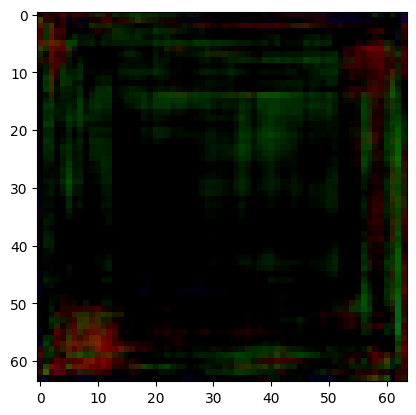

In [ ]:
import matplotlib.pyplot as plt
print(video.shape)
plt.imshow(video[0][:, 0, ...].permute(1, 2, 0).cpu().detach().numpy())
plt.show()
